# Import

In [1]:
%matplotlib inline
import os
from time import time
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import MeanShift, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
import math
import sys 
sys.path.append(os.path.abspath("/Users/evamartinez/Code/ocr_segmentez_client"))
import segmentez as seg
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering


# Clustering Librairies import
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance


# mpl.rcParams["figure.figsize"] = (12, 8)
init_notebook_mode()
warnings.filterwarnings('ignore')

# Data processing and visualization

### Load data

In [2]:
df_rfmr_raw = pd.read_csv('df_rfmr_raw.csv')
df_rfmr_raw = df_rfmr_raw.set_index('customer_unique_id')

df_rfmr = pd.read_csv('df_rfmr.csv')
df_rfmr = df_rfmr.set_index('customer_unique_id')




#### See Distribution of unscaled data

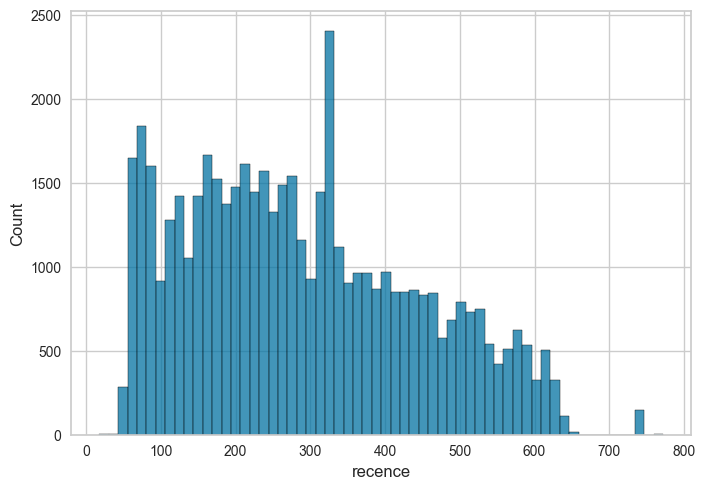

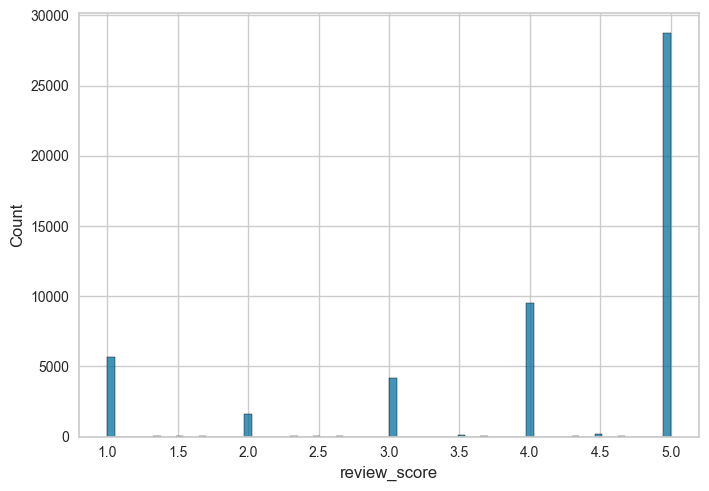

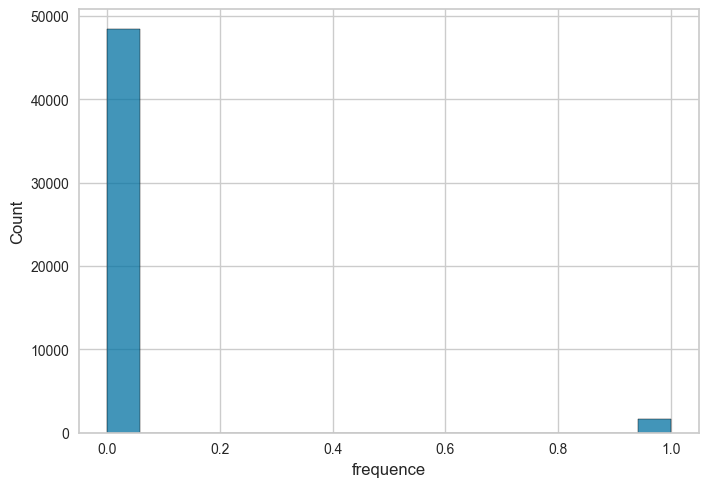

In [3]:
col = df_rfmr.columns
# Histograms
for i, col in enumerate(df_rfmr):
  plt.figure(i)
  sns.histplot(df_rfmr[col])


### Pre-processing

In [4]:
categorical_features = ['frequence']
numerical_features = ['monetary_log','recence','review_score']

# Scaler
scaler = MinMaxScaler()

# Build the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', scaler, numerical_features)
    ],remainder='passthrough'
)


### Distribution of scaled data

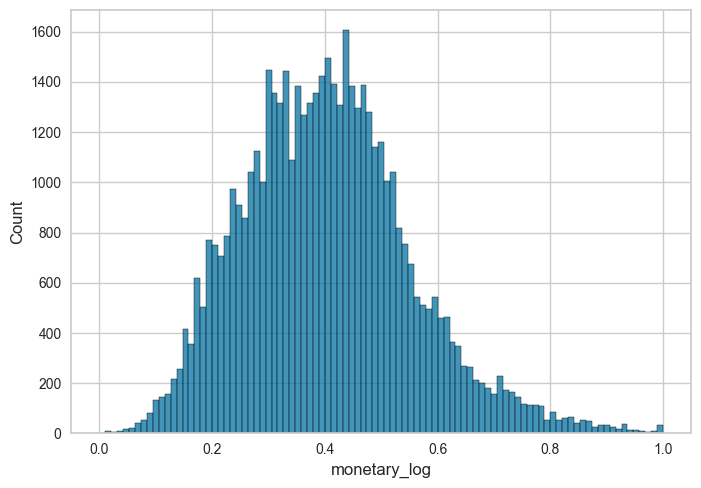

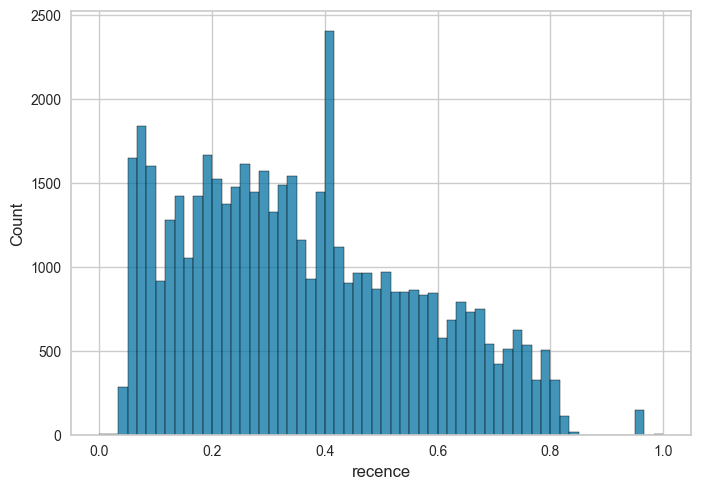

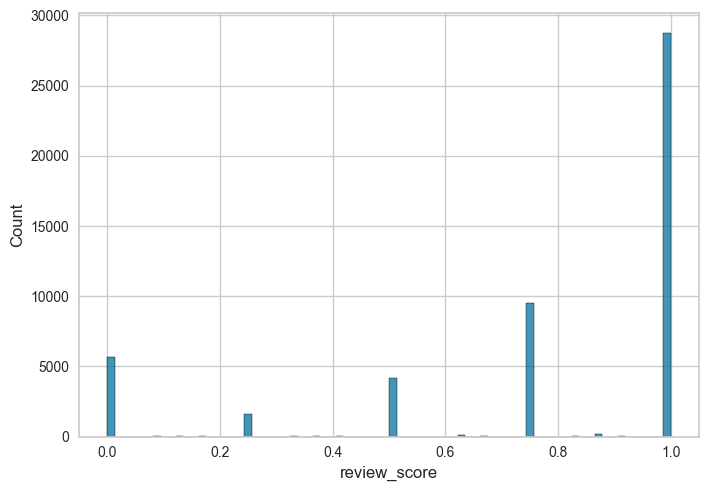

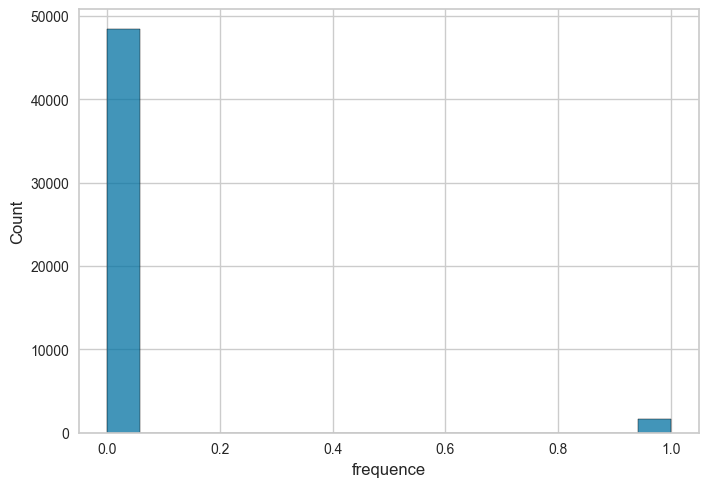

In [5]:
X = df_rfmr.copy()


X_scaled = preprocessor.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=['monetary_log','recence','review_score', 'frequence'])
X_scaled_df.shape

# Histograms
for i, col in enumerate(X_scaled_df):
  plt.figure(i)
  sns.histplot(X_scaled_df[col])
  plt.savefig("histscaled"+str(i)+".png")


### PCA

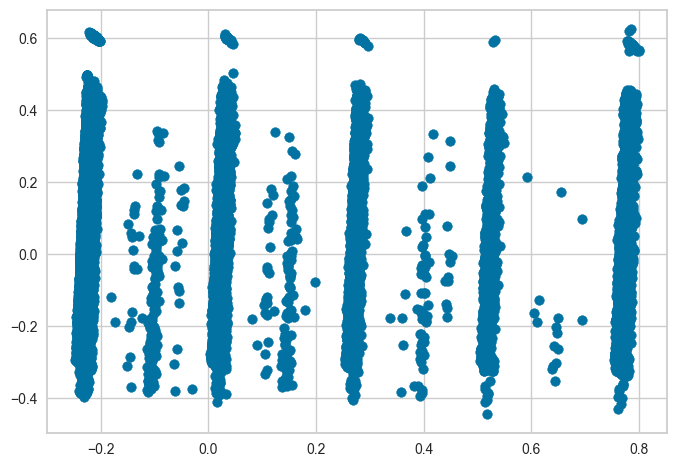

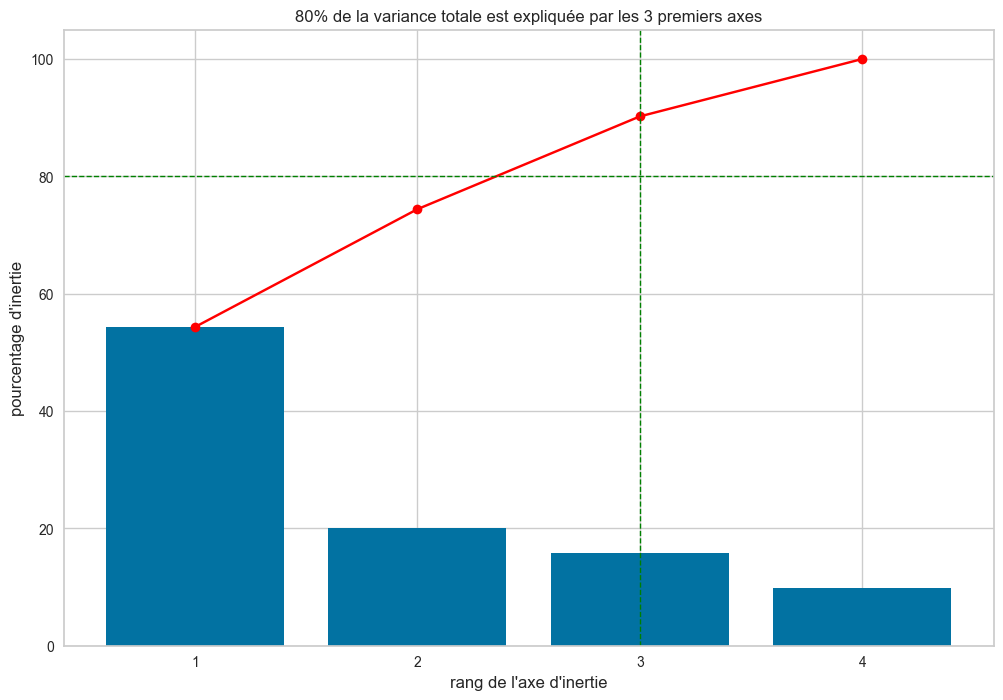

In [6]:
# PCA Pipeline
pca = Pipeline([("preprocessor", MinMaxScaler()),
                ("pca", PCA(svd_solver='full'))])
X_trans_pca = pca.fit_transform(X)
plt.scatter(X_trans_pca[:,0],X_trans_pca[:,1])


# Explained variance
varexpl = pca.named_steps['pca'].explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=80, linestyle="--", 
            color="green",
            linewidth=1)

limit = 80
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)


### TSNE

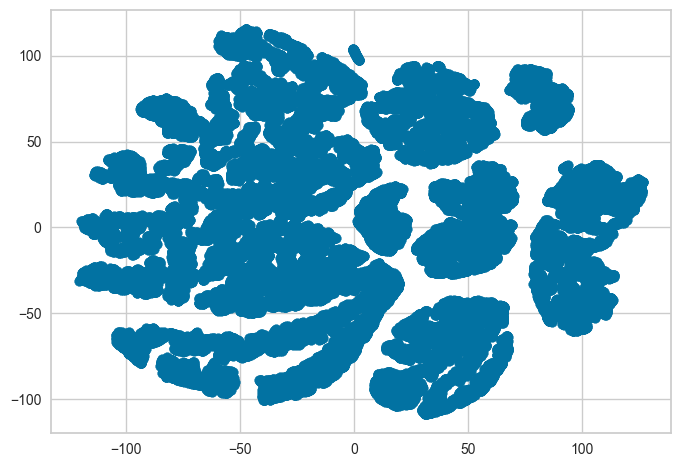

In [7]:
tsne = Pipeline([("preprocessor", MinMaxScaler()),
                ("tsne", TSNE(n_components=2,perplexity=60))]) 
X_trans_tsne = tsne.fit_transform(X)
plt.scatter(X_trans_tsne[:, 0], X_trans_tsne[:, 1])


# Clustering

## Homemade clustering

49998
49998
monetary 12.28 13664.08
review_score 1.0 5.0
recence 18 772
frequence 1 9
19.0 4.0
Index(['customer_unique_id', 'recence', 'frequence', 'monetary',
       'review_score', 'frequence_quanti', 'recence_quanti', 'monetary_quanti',
       'total_rfm', 'labels'],
      dtype='object')


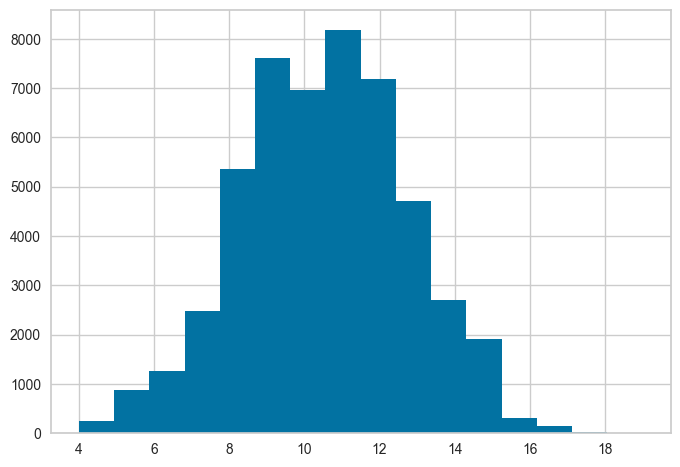

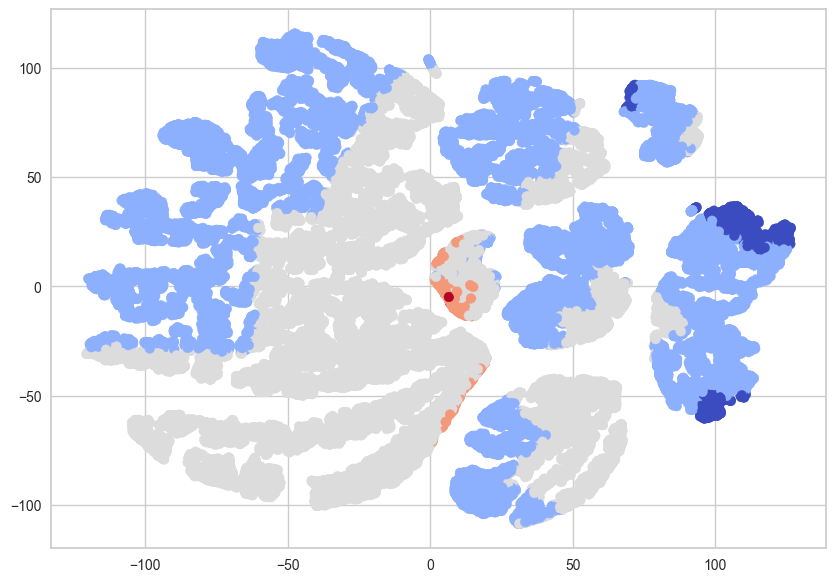

In [8]:
df_rfmr_quanti = pd.read_csv('df_rfmr_raw.csv')

for custumer in df_rfmr_quanti.index:
  if df_rfmr_quanti.loc[custumer,'frequence'] ==1:
    df_rfmr_quanti.loc[custumer,'frequence_quanti'] = 1
  if df_rfmr_quanti.loc[custumer,'frequence'] ==2:
    df_rfmr_quanti.loc[custumer,'frequence_quanti'] = 3
  if df_rfmr_quanti.loc[custumer,'frequence'] >2 and df_rfmr_quanti.loc[custumer,'frequence'] <=5:
    df_rfmr_quanti.loc[custumer,'frequence_quanti'] = 4
  if df_rfmr_quanti.loc[custumer,'frequence'] >5:
    df_rfmr_quanti.loc[custumer,'frequence_quanti'] = 5

for custumer in df_rfmr_quanti.index:
  # les deux derniers mois
  if df_rfmr_quanti.loc[custumer,'recence'] <= 60:
    df_rfmr_quanti.loc[custumer,'recence_quanti'] = 5

  # les deux derniers mois et 6 mois
  if df_rfmr_quanti.loc[custumer,'recence'] > 60 and df_rfmr_quanti.loc[custumer,'recence'] <= 182:
    df_rfmr_quanti.loc[custumer,'recence_quanti'] = 4

  # 6 mois et 1 an
  if df_rfmr_quanti.loc[custumer,'recence'] > 182  and df_rfmr_quanti.loc[custumer,'recence'] <= 365 :
    df_rfmr_quanti.loc[custumer,'recence_quanti'] = 2
  
  # Plus de 1 an
  if df_rfmr_quanti.loc[custumer,'recence'] > 365:
    df_rfmr_quanti.loc[custumer,'recence_quanti'] = 1


for custumer in df_rfmr_quanti.index:
  if df_rfmr_quanti.loc[custumer,'monetary'] <= np.quantile(df_rfmr_quanti['monetary'], .20):
    df_rfmr_quanti.loc[custumer,'monetary_quanti'] = 1
  if df_rfmr_quanti.loc[custumer,'monetary'] > np.quantile(df_rfmr_quanti['monetary'], .20) and df_rfmr_quanti.loc[custumer,'monetary'] <= np.quantile(df_rfmr_quanti['monetary'], .40):
    df_rfmr_quanti.loc[custumer,'monetary_quanti'] = 2
  if df_rfmr_quanti.loc[custumer,'monetary'] > np.quantile(df_rfmr_quanti['monetary'], .40) and df_rfmr_quanti.loc[custumer,'monetary'] <= np.quantile(df_rfmr_quanti['monetary'], .60):
    df_rfmr_quanti.loc[custumer,'monetary_quanti'] = 3
  if df_rfmr_quanti.loc[custumer,'monetary'] > np.quantile(df_rfmr_quanti['monetary'], .60) and df_rfmr_quanti.loc[custumer,'monetary'] <= np.quantile(df_rfmr_quanti['monetary'], .80):
    df_rfmr_quanti.loc[custumer,'monetary_quanti'] = 4
  if df_rfmr_quanti.loc[custumer,'monetary'] > np.quantile(df_rfmr_quanti['monetary'], .80):
    df_rfmr_quanti.loc[custumer,'monetary_quanti'] = 5


df_rfmr_quanti['total_rfm']=df_rfmr_quanti['monetary_quanti']+df_rfmr_quanti['recence_quanti']+df_rfmr_quanti['frequence_quanti']+df_rfmr_quanti['review_score']
df_rfmr_quanti['total_rfm']= round(df_rfmr_quanti['total_rfm'])

max = df_rfmr_quanti['total_rfm'].max()
min = df_rfmr_quanti['total_rfm'].min()

print('max : ',max, 'min :', min)

plt.hist(df_rfmr_quanti['total_rfm'],bins = 16)
plt.title("total_rfm")

labels =[]

for i in range(0,len(df_rfmr_quanti)):
  if df_rfmr_quanti.iloc[i,df_rfmr_quanti.columns.get_loc('total_rfm')] <= 5:
    labels.append(1)
  if df_rfmr_quanti.iloc[i,df_rfmr_quanti.columns.get_loc('total_rfm')] > 5 and df_rfmr_quanti.iloc[i,df_rfmr_quanti.columns.get_loc('total_rfm')] <= 10 :
    labels.append(2)
  if df_rfmr_quanti.iloc[i,df_rfmr_quanti.columns.get_loc('total_rfm')] > 10 and df_rfmr_quanti.iloc[i,df_rfmr_quanti.columns.get_loc('total_rfm')] <= 15 :
    labels.append(3)
  if df_rfmr_quanti.iloc[i,df_rfmr_quanti.columns.get_loc('total_rfm')] > 15 and df_rfmr_quanti.iloc[i,df_rfmr_quanti.columns.get_loc('total_rfm')] <= 18 :
    labels.append(4)
  if df_rfmr_quanti.iloc[i,df_rfmr_quanti.columns.get_loc('total_rfm')] > 18:
    labels.append(5)

df_rfmr_quanti['labels'] = labels

print(df_rfmr_quanti.columns)

plt.figure(figsize=(10, 7))
plt.scatter(X_trans_tsne[:, 0], X_trans_tsne[:, 1], c=df_rfmr_quanti['labels'],cmap ='coolwarm')

## DBScan

eps 0.1
neighs 3
score 0.19259010908914312
eps 0.1
neighs 8
score 0.20529274667147784
eps 0.8
neighs 3
score 0.5543006393878352
eps 0.8
neighs 8
score 0.5543006393878352
4
4


<Axes: >

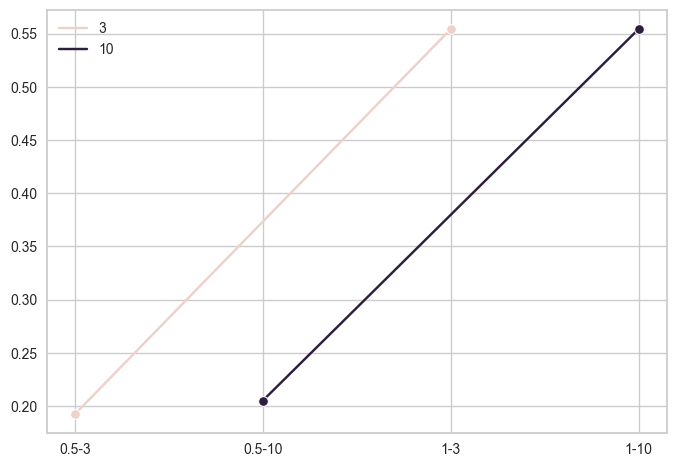

In [18]:
eps = [0.1,0.8]
neighs = [3,8]
silhouettes = []
i = 0
score_max = 0
v_eps = 0
v_neigh = 0
for ep in eps:
    for n in neighs:
        db = Pipeline([("preprocessor", preprocessor),
                         ("dbscan", DBSCAN(eps=ep, min_samples=n))])
        db.fit(X)
        print('eps',ep)
        print('neighs',n)
        score = metrics.silhouette_score(X_scaled, db.named_steps['dbscan'].labels_)
        print('score',score)
        silhouettes.append(score)
        if i == 0:
            v_eps = ep
            v_neigh = n
            score_max = score
            i += 1
        else:
            if score > score_max:
                v_eps = ep
                v_neigh = n
                score_max = score

title = ['0.5-3','0.5-10','1-3','1-10']
sns.lineplot(x=title, y=silhouettes,hue=[3, 10, 3,10], marker="o")

### TSNE colored with labels

0.8 3
Estimated number of clusters: 793
Estimated number of noise points: 1031
Silhouette Coefficient: 0.065


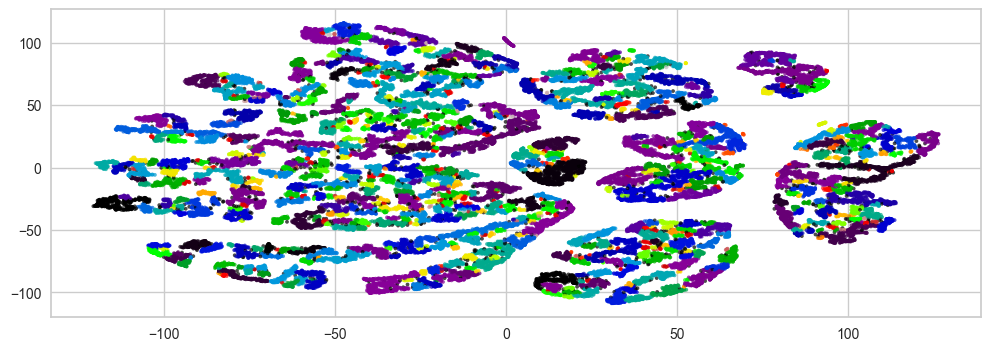

In [19]:
print(v_eps,v_neigh)
db = DBSCAN(eps=v_eps, min_samples=v_neigh).fit(X_trans_tsne)

db.fit(X_trans_tsne)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_trans_tsne, labels))

# Black removed and is used for noise instead.
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(12, 4)
colors = cm.nipy_spectral(labels.astype(float) / n_clusters_)
ax1.scatter(X_trans_tsne[:, 0], X_trans_tsne[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')
plt.show()

## Hierarchical clustering

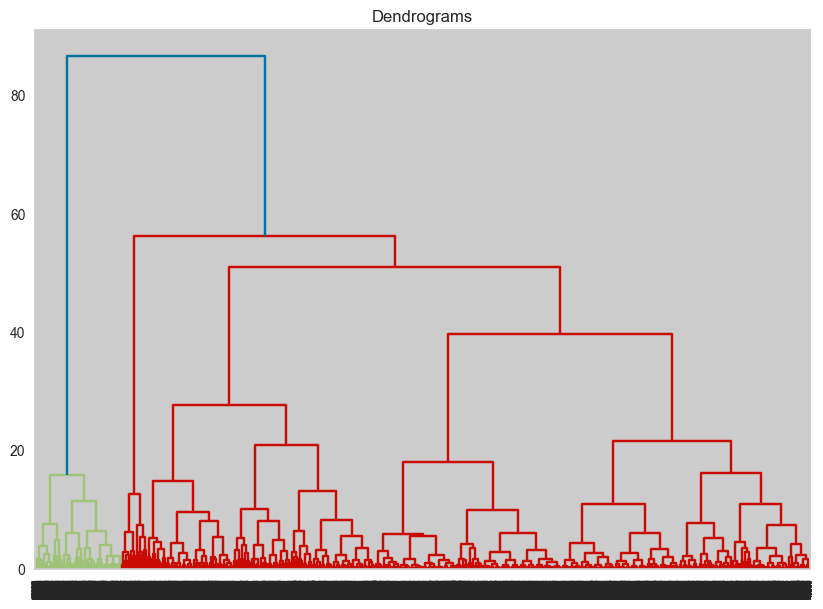

In [20]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X_scaled, method='ward'))

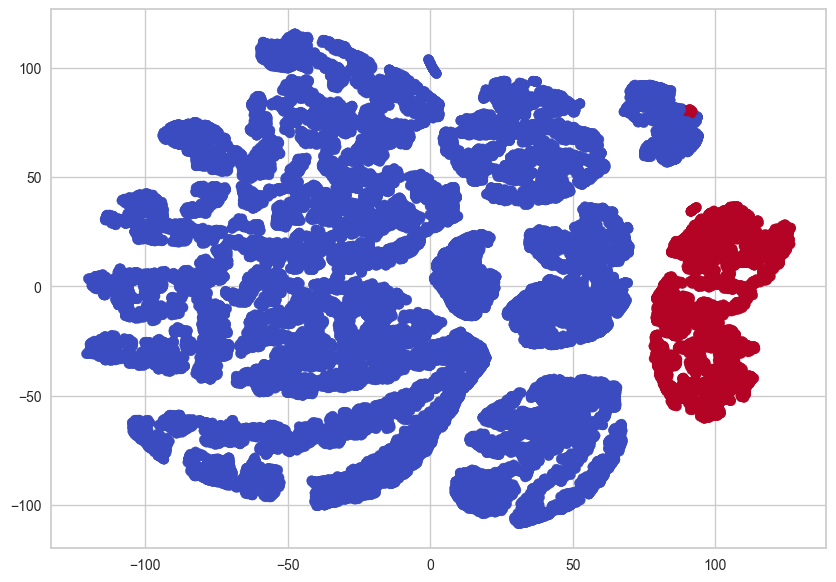

In [21]:
hierarchical_model = AgglomerativeClustering(n_clusters=2,linkage='ward')
hierarchical_model.fit(X_scaled)
plt.figure(figsize=(10, 7))  
plt.scatter(X_trans_tsne[:, 0], X_trans_tsne[:, 1], c=hierarchical_model.labels_,cmap ='coolwarm') 

## Kmeans

### Find best K

#### Elbow

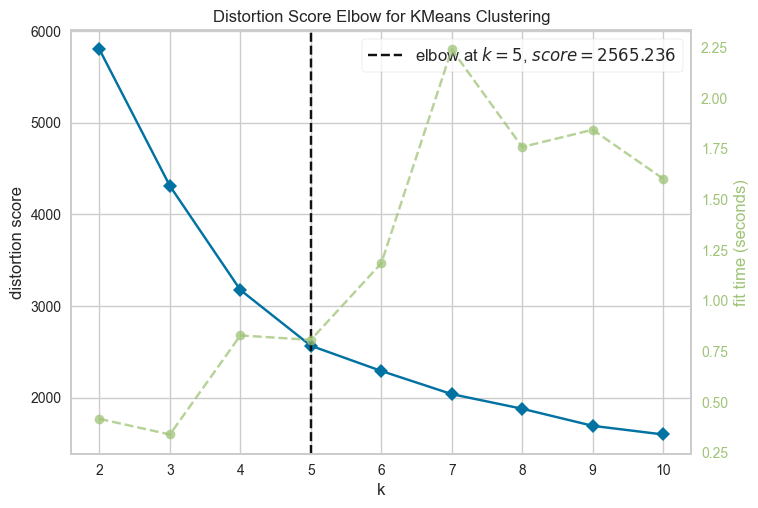

Index(['recence', 'review_score', 'frequence', 'monetary_log'], dtype='object')


In [9]:
# Elbow method
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(4,7)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

print(X.columns)

#### Silhouette

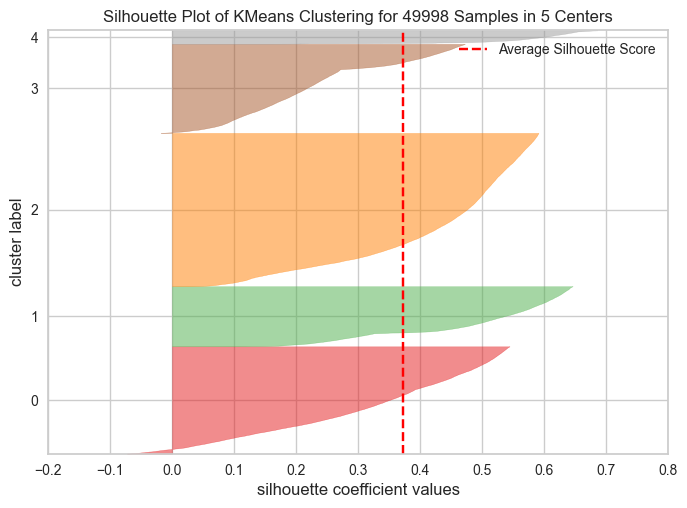

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 49998 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [10]:
# Best K in Elbow
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_

# Silhouette Visualizer
silhouette_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

### Pipeline Kmeans

In [ ]:
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X)

# Kmeans labels
kmeans_labels = kmeans_model.named_steps['kmeans'].labels_


### Radar plot

[0, 1.5707963267948966, 3.141592653589793, 4.71238898038469]
[0, 1.5707963267948966, 3.141592653589793, 4.71238898038469]
[0, 1.5707963267948966, 3.141592653589793, 4.71238898038469]
[0, 1.5707963267948966, 3.141592653589793, 4.71238898038469]
[0, 1.5707963267948966, 3.141592653589793, 4.71238898038469]


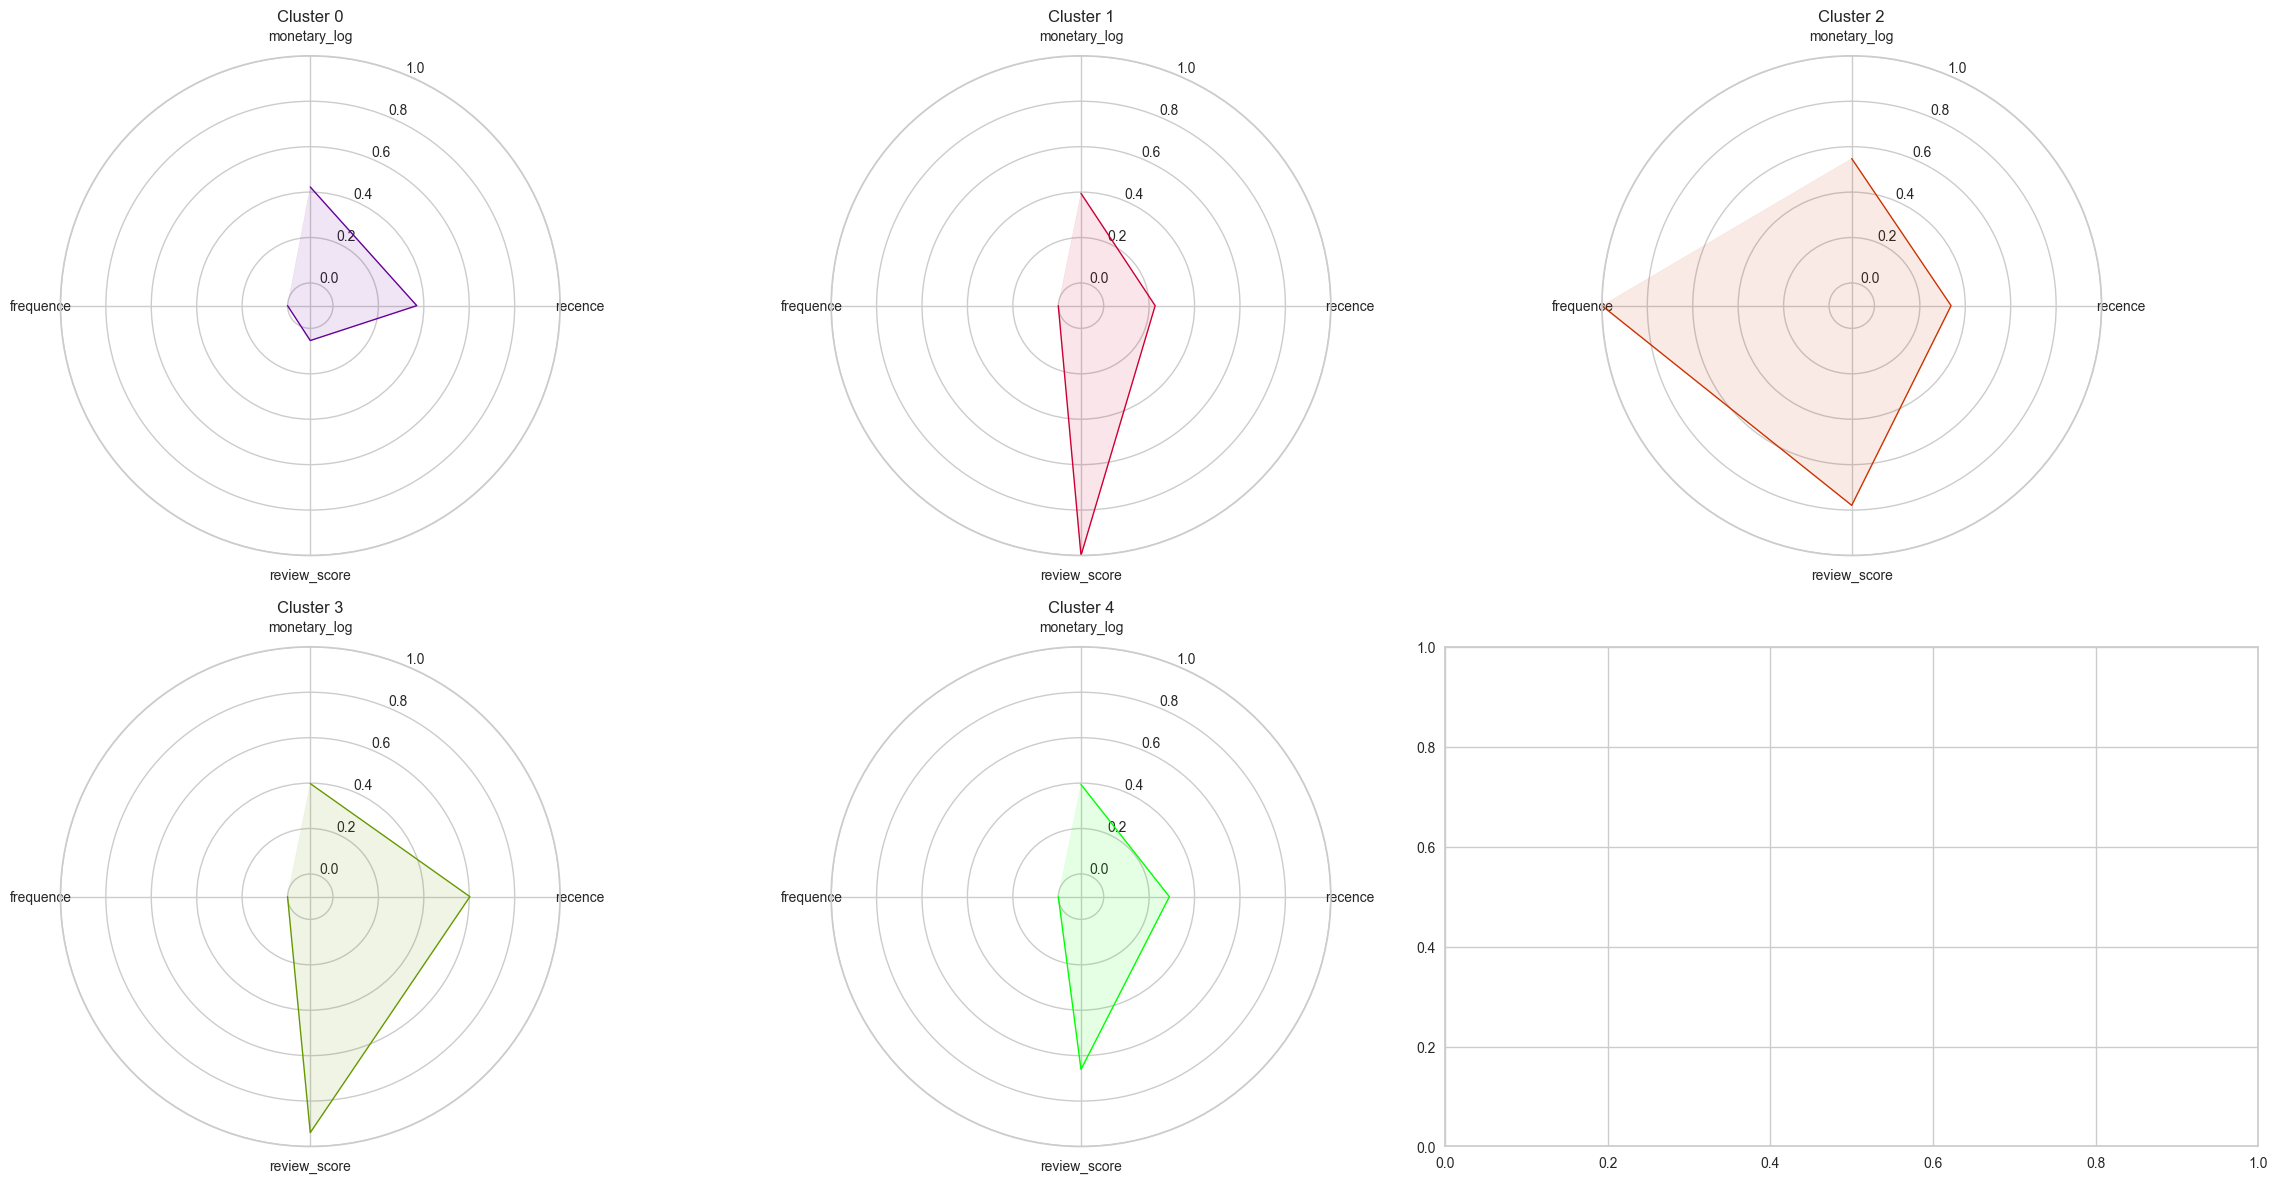

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(24, 12), tight_layout=12.0)

features = ['monetary_log','recence','review_score', 'frequence']

colors = ['#660099', '#cc0033', '#cc3300', '#669900', '#00ff00']

angles = [ 0, 0.5 * math.pi, math.pi, 1.5 * math.pi]

for i, center in enumerate(kmeans_model.named_steps['kmeans'].cluster_centers_):
    lin, col = i // 3, i % 3
    
    ax[lin, col] = plt.subplot(2, 3, i + 1, projection='polar')
    ax[lin, col].set_title('Cluster ' + str(i))
    ax[lin, col].set_theta_offset(math.pi / 2)
    ax[lin, col].set_theta_direction(-1)
    ax[lin, col].set_rlim(-0.1, 1)
    
    print(angles)
    plt.xticks(angles, features)
    
    values = list(center)
    ax[lin, col].plot(angles, values, linewidth=1, linestyle='solid', color=colors[i])
    ax[lin, col].fill(angles, values, color=colors[i], alpha=0.1)

fig.show()

### PCA colored with labels

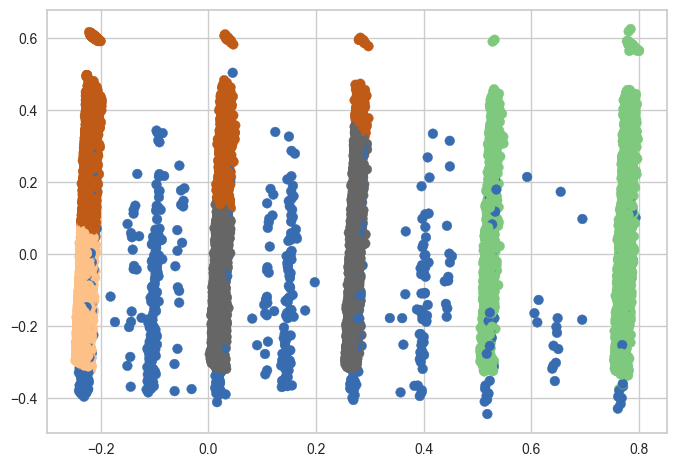

In [13]:
plt.figure()
plt.scatter(X_trans_pca[:,0],X_trans_pca[:,1],c=kmeans_labels,cmap = 'Accent')
plt.show()

### TSNE colored with labels

#### 1st iteration

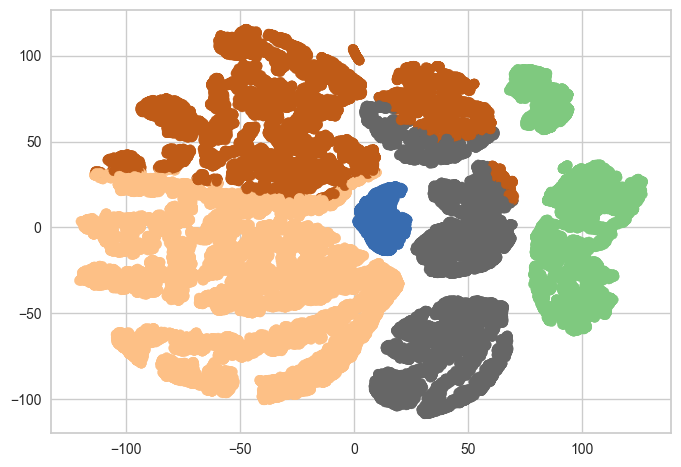

In [14]:
plt.figure()
plt.scatter(X_trans_tsne[:,0],X_trans_tsne[:,1],c=kmeans_labels,cmap = 'Accent')
plt.show()

#### 2nd iteration

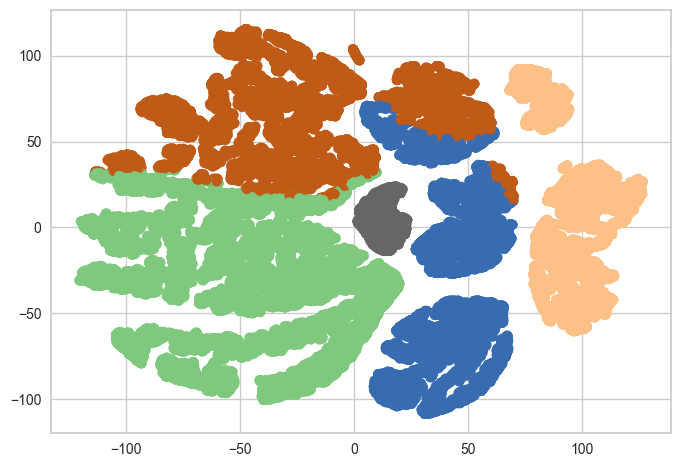

In [15]:
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X)

# Kmeans labels
kmeans_labels_iter2 = kmeans_model.named_steps['kmeans'].labels_

plt.figure()
plt.scatter(X_trans_tsne[:,0],X_trans_tsne[:,1],c=kmeans_labels_iter2,cmap = 'Accent')
plt.show()

#### ARI score

In [16]:
adjusted_rand_score(kmeans_labels, kmeans_labels_iter2)

0.9983386029404923

### TSNE colored with indicators

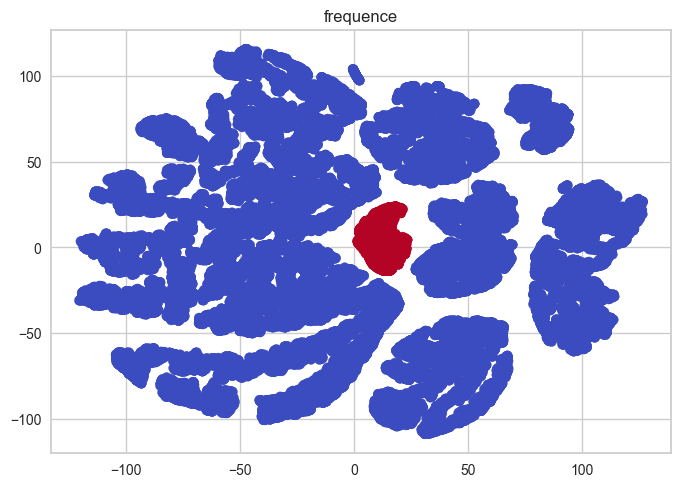

In [17]:
list_indicateurs = ['monetary_log','recence','review_score', 'frequence']

for indicateur in range (0,4): 
  plt.figure()
  plt.title(list_indicateurs[indicateur])
  plt.scatter(X_trans_tsne[:,0],X_trans_tsne[:,1],c=X_scaled[:,indicateur],cmap ='coolwarm')
  plt.show()


### Kmeans Model differs over time

In [22]:
import importlib
from dateutil.relativedelta import relativedelta
from datetime import datetime, timedelta

importlib.reload(seg)
df_orders_final_notready = pd.read_csv('df_orders_final.csv')


# We will get the last date - 1month because we don't have much order the last month
datetime_list = []
for i in df_orders_final_notready['order_purchase_timestamp']:
    datetime_object = datetime.strptime(i, '%Y-%m-%d %H:%M:%S')
    datetime_list.append(datetime_object)
df_orders_final_notready['date_formatted'] = datetime_list
del df_orders_final_notready['order_purchase_timestamp']  
date_most_recent = df_orders_final_notready['date_formatted'].max()
date_most_recent_new = date_most_recent - relativedelta(months=1)
date_begin = df_orders_final_notready['date_formatted'].min()
df_orders_final =df_orders_final_notready.loc[df_orders_final_notready["date_formatted"].between(date_begin, date_most_recent_new)]

# mr = most_recent
# lr = less_recent 


list_weeks= [2,4,12,24,48]
dict_ari = {}
for i in list_weeks:
    period_lr,period_mr = seg.get_period(df_orders_final,i)

    df_filtered_period_lr = seg.get_period_orders(df_orders_final,period_lr)
    df_filtered_period_mr = seg.get_period_orders(df_orders_final,period_mr)
    df_rfmr_lr = seg.compute_features_df(df_filtered_period_lr)
    df_rfmr_mr = seg.compute_features_df(df_filtered_period_mr)
    model_lr = seg.compute_model(df_rfmr_lr)
    model_mr = seg.compute_model(df_rfmr_mr)

    ari = seg.predict_and_score(model_lr,model_mr,df_rfmr_mr)

    if i == 2:
        period = 'semaines'
        period_nb = i
    else :
        period = 'mois'
        period_nb = int(i/4)

    print(f'Pour {period_nb} {period} le score ARI est de : {ari}')



Pour 2 semaines le score ARI est de : 0.009433962264150943
Pour 1 mois le score ARI est de : 0.7233638114037687
Pour 3 mois le score ARI est de : 0.5732331757045717
Pour 6 mois le score ARI est de : 0.5976970315816538
Pour 12 mois le score ARI est de : 0.7120249608736601
